In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

## Kern County

### Read in data

In [3]:
df = pd.read_excel('../data/MasterDF_Kern.xlsx', sheet_name='data')
df.head()

,FID,Area,Crop,CropX,FieldCropPrice,PricePerAcre,SavedWater,Recharge,Kitfox,KitfoxAcres,...,GiantGarterSnake,GGSAcres,TNC,HabCorridors,ConservationAreas,ImpBirdAreas,Nitrate,ModSAGBI,Prox2Wetlands,Depth2GroundWater
0,45,70.791382,AlfalfaandAlfalfaMixtures,alfalfa-pasture,78836.822442,1113.65,359.620220,12283.604016,100.0,70.791382,...,0.0,0.000000,94.0,0.0,100.0,0.0,0.000000,42.0,0.0,20.0
1,72,81.343317,AlfalfaandAlfalfaMixtures,alfalfa-pasture,90587.985155,1113.65,413.224051,1975.754272,100.0,81.343317,...,100.0,81.343317,0.0,0.0,100.0,0.0,100.000000,0.0,100.0,5.0
2,91,28.286742,AlfalfaandAlfalfaMixtures,alfalfa-pasture,31501.529705,1113.65,143.696647,3311.302980,100.0,28.286742,...,0.0,0.000000,0.0,0.0,46.0,91.0,93.333333,98.0,0.0,20.0
3,116,6.073612,AlfalfaandAlfalfaMixtures,alfalfa-pasture,6763.878538,1113.65,30.853951,417.364790,100.0,6.073612,...,0.0,0.000000,0.0,0.0,100.0,0.0,83.333333,75.5,0.0,11.5
4,143,97.932855,AlfalfaandAlfalfaMixtures,alfalfa-pasture,109062.924182,1113.65,497.498904,11437.290065,100.0,97.932855,...,4.0,3.917314,0.0,83.0,100.0,0.0,0.000000,97.0,100.0,20.0


In [4]:
targets = pd.read_csv('../data/targets.csv', index_col='region', thousands=',')
targets

,alfalfa-pasture,corn,field-crops-grains,veg-fruits,trees-vines
region,,,,,
NW,21320.0,8400.0,85920.0,3880.0,3880.0
NE,56850.0,7750.0,23580.0,2260.0,16800.0
SW,36820.0,3880.0,72350.0,8400.0,7750.0
SE,38760.0,16150.0,124030.0,650.0,9690.0
KR,88500.0,54910.0,42640.0,3230.0,11630.0


### Area-weight all ecosystem services columns
TO DO: Need to confirm that measures are not yet area weighted

TO DO: Adjust outcome_cols in bootstrap module

### Model Business as Usual Case

In [103]:
# specify region, list of crop types, and list of ecosystem service outcomes to track
# set up dataframe to store outcomes of each trial
# for 1000 tries:
#    set up master df (shape = 0 x number of columns of df)
#    for crop in crop type:
#        subset dataset, get target, check that sufficient area is available
#        randomly sort the df
#        subset to meet target
#        append to master df
#    calculate total ecosystem services accumulated and acres faLLowed in master df
#    append outcomes to trials dataframe

region = 'KR'
crop_types = targets.columns
outcome_cols = ['Area','KitfoxAcres', 'GGSAcres']
trials = pd.DataFrame(columns=outcome_cols)

for i in range(10):
    df_fallow = pd.DataFrame(columns=df.columns)
    for crop in crop_types:
        df_crop = df[df['CropX'] == crop]
        target = targets.loc[region, crop]
        df_crop_shuffle = df_crop.sample(n=df_crop.shape[0])
        df_crop_shuffle.sort_values('PricePerAcre', inplace=True)
        # Identify fields up to target
        df_fallow_bool = df_crop_shuffle['Area'].cumsum() < target
        # Get one additional field by updating value from False to True where 
        # first instance of False is located
        if not df_fallow_bool[df_fallow_bool!=True].empty:
            index = df_fallow_bool[df_fallow_bool!=True].index[0]
            df_fallow_bool.at[index]=True        
        df_crop_fallow = df_crop_shuffle[df_fallow_bool]
        df_fallow = df_fallow.append(df_crop_fallow, ignore_index=True)
    outcomes = pd.DataFrame(df_fallow[outcome_cols].sum()).T
    areas = df_fallow[['Area','CropX']].groupby('CropX').sum().T
    areas.reset_index(drop=True, inplace=True)
    output = pd.concat([outcomes, areas], axis=1, sort=False)
    trials = trials.append(output, ignore_index=True, sort=False)

In [104]:
trials

,Area,KitfoxAcres,GGSAcres,alfalfa-pasture,corn,field-crops-grains,trees-vines,veg-fruits
0,162052.893594,161906.107618,53706.626679,80767.856997,23740.216326,42647.846969,11630.997292,3265.976010
1,162044.305986,161897.520010,53025.677314,80767.856997,23740.216326,42665.815737,11632.112371,3238.304556
2,162136.621475,161989.835499,53228.993563,80767.856997,23740.216326,42709.720128,11652.852013,3265.976010
3,162190.936378,162044.150402,53451.902595,80767.856997,23740.216326,42800.142110,11643.782327,3238.938618
4,162141.204916,161994.418940,52926.435032,80767.856997,23740.216326,42750.930414,11630.674175,3251.527004
5,162019.686291,161872.900316,53108.840308,80767.856997,23740.216326,42641.553179,11630.266836,3239.792954
6,162079.851280,161933.065304,52929.931724,80767.856997,23740.216326,42646.135552,11659.666395,3265.976010
7,162062.158237,161915.372261,52947.133642,80767.856997,23740.216326,42674.203069,11641.577290,3238.304556
8,162126.178000,161979.392024,53053.638504,80767.856997,23740.216326,42733.566878,11645.696960,3238.840839
9,162123.683555,161976.897580,53672.834986,80767.856997,23740.216326,42709.029167,11640.923109,3265.657958


### Visualize results

#### Ensure sufficient acreage fallowed

In [108]:
# Bar chart with each crop type on x-axis, acreage fallowed as bars, and targets as dots. Visualize difference between
# acreage fallowed and target for each crop type in one chart.


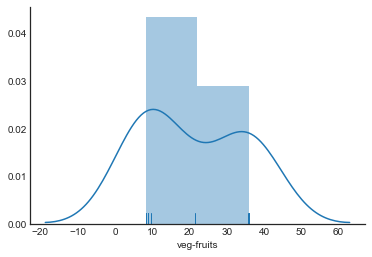

In [107]:
crop_type = 'veg-fruits'
sns.distplot(trials[crop_type]-targets.loc[region, crop_type], rug=True)
sns.despine()

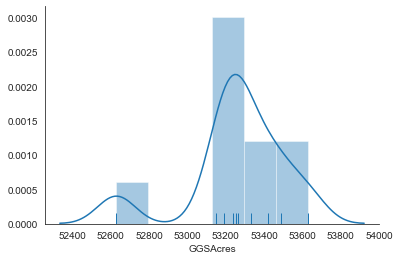

In [150]:
sns.distplot(trials['GGSAcres'], rug=True)
sns.despine()

### Exploration

In [97]:
df2 = df_crop_shuffle['Area'].cumsum() < target

In [98]:
index = df2[df2!=True].index[0]
index

3155

In [99]:
df2.loc[index]

False

In [100]:
df2.at[index]=True

In [56]:
# df2.at[df2[df2!=True].index[0]]=True

In [102]:
df2.loc[index]

True

In [8]:
#Subset df by crop type
crop_type = 'alfalfa-pasture'

df_alfalfa = df[df['CropX'] == crop_type]

#Specify the target
target = targets_kr[crop_type]

# Check that sufficient area is available to meet target
print("{}, crop area is equal to {:,.2f} and target is {:,.2f}".format(df_alfalfa.Area.sum() > target, df_alfalfa.Area.sum(), target))

False, crop area is equal to 80,767.86 and target is 88,500.00


In [9]:
#Randomly sort the data
df_alfalfa_random = df_alfalfa.sample(n=df_alfalfa.shape[0])

#Select fields until target is reached.
df_alfalfa_fallow = df_alfalfa_random[df_alfalfa_random['Area'].cumsum() < target]

#Check that target is met
df_alfalfa_fallow.Area.sum()

80767.85699677002

In [10]:
df_alfalfa_fallow.head()

,FID,Area,Crop,CropX,FieldCropPrice,SavedWater,Recharge,Kitfox,KitfoxAcres,TiptonKRat,GiantGarterSnake,GGSAcres,TNC,HabCorridors,ConservationAreas,ImpBirdAreas,Nitrate,ModSAGBI,Prox2Wetlands,Depth2GroundWater
388,6167,73.583013,AlfalfaandAlfalfaMixtures,alfalfa-pasture,81945.721915,373.801704,5193.151323,100.0,73.583013,100.0,0.0,0.000000,0.0,0.0,18.666667,0.0,97.777778,17.333333,39.333333,10.0
446,7056,60.724463,AlfalfaandAlfalfaMixtures,alfalfa-pasture,67625.798610,308.480274,6259.313794,100.0,60.724463,100.0,0.0,0.000000,0.0,0.0,0.000000,0.0,71.111111,0.000000,0.000000,20.0
47,761,45.041234,AlfalfaandAlfalfaMixtures,alfalfa-pasture,50160.170745,228.809471,5207.508907,100.0,45.041234,100.0,0.0,0.000000,0.0,0.0,0.000000,0.0,86.666667,95.000000,0.000000,20.0
362,5664,13.695583,AlfalfaandAlfalfaMixtures,alfalfa-pasture,15252.085863,69.573561,332.653097,100.0,13.695583,100.0,100.0,13.695583,0.0,100.0,100.000000,100.0,86.666667,0.000000,100.000000,10.0
1067,15912,63.793587,AlfalfaandAlfalfaMixtures,alfalfa-pasture,71043.728207,324.071422,5502.933085,100.0,63.793587,100.0,0.0,0.000000,0.0,0.0,0.000000,0.0,81.111111,35.000000,0.000000,20.0


In [11]:
#Sum the ecosystem services gained
kitfox = df_alfalfa_fallow.KitfoxAcres.sum()
kitfox

80621.07102097

In [12]:
outcomes = pd.DataFrame(df_fallow[outcome_cols].sum()).T
    areas = df_fallow[['Area','CropX']].groupby('CropX').sum().T
    areas.reset_index(drop=True, inplace=True)
    output = pd.concat([outcomes, areas], axis=1, sort=False)
    trials = trials.append(output, ignore_index=True, sort=False)